In [1]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy
import atlas_mpl_style as ampl
ampl.use_atlas_style(usetex=False)
from pathlib import Path
from tqdm import tqdm
import numpy as np
from core.utils import *
import atlas_mpl_style as ampl
ampl.use_atlas_style(usetex=False)

In [2]:
pkl_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new'
pkl_path = Path(pkl_path)

In [3]:
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'SFs_pkls'

In [4]:
reweighting_vars = ['jet_nTracks', 'GBDT_newScore']
nominal_keys = [reweighting_var + '_quark_reweighting_weights' for reweighting_var in reweighting_vars]
WPs = [0.5, 0.6, 0.7, 0.8]


In [5]:
SFs = joblib.load(nominal_path / nominal_keys[0] / "SFs.pkl") # this includes many vars with WPs 

In [6]:
syst_config ={
    "trk_eff": {
        "has_subtype": True,
        "syst_subtype": trk_eff_uncertainties,
        "handle": 'quadratic',
    },
    "JESJER": {
        "has_subtype": True,
        "syst_subtype": JESJER_uncertainties,
        "handle": 'envelope',
    },
    "MC_nonclosure":{
        "has_subtype": False,
    },
    "gluon_reweight":{
        "has_subtype": False,
    },
    "pdf_weight":{
        "has_subtype": True,
        "syst_subtype": pdf_weight_uncertainties,
        "handle": 'envelope',
    },
    "scale_variation":{
        "has_subtype": True,
        "syst_subtype": scale_variation_uncertainties[2:9],
        "handle": 'envelope',
    },
    "matrix_element":{
        "has_subtype": True,
        "syst_subtype": matrix_element_uncertainties,
        "handle": 'envelope',
    },
    "parton_shower":{
        "has_subtype": True,
        "syst_subtype": parton_shower_uncertainties,
        "handle": 'envelope',
    },
    "hadronization":{
        "has_subtype": True,
        "syst_subtype": hadronization_uncertainties,
        "handle": 'envelope',
    },
}

special_processing = ['parton_shower', 'hadronization']

In [ ]:
syst_total = dict.fromkeys(reweighting_vars)
for i_var, reweighting_var in enumerate(reweighting_vars):
    nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'SFs_pkls'
    nominal_SFs = joblib.load(nominal_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 

    syst_total[reweighting_var] = dict.fromkeys(syst_config.keys()) # syst_total['trk_eff', 'JESJER',...]
    for syst_type, value in tqdm(syst_config.items()):
        syst_total[reweighting_var][syst_type] = syst_total.fromkeys(WPs) # syst_total['trk_eff'][0.5,0.6,0.7,0.8]

        if syst_type in special_processing:
            if value['has_subtype'] and len(value['syst_subtype'])==2:
                syst_sub_var = dict.fromkeys(value['syst_subtype'])
                nominal_path = pkl_path / syst_type / value['syst_subtype'][0] / 'plots' / 'ADE' / 'SFs_pkls'
                nominal_SFs = joblib.load(nominal_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 

                for syst_subtype in value['syst_subtype']: # loop on ['fake', 'eff'] 
                    syst_sub_var[syst_subtype] = dict.fromkeys(WPs) # syst_sub_var['eff'][0.5,0.6,0.7,0.8]
                    syst_path = pkl_path / syst_type / syst_subtype / 'plots' / 'ADE' / 'SFs_pkls'
                    syst_SFs = joblib.load(syst_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 

                    for WP in WPs:
                        syst_sub_var[syst_subtype][WP] = {
                            "Quark":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Quark"] \
                                                        - syst_SFs[reweighting_var][WP]["Quark"]),
                            "Gluon":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Gluon"] \
                                                        - syst_SFs[reweighting_var][WP]["Gluon"]),                                                       
                        } 
                
                if value['handle'] == 'envelope':
                    for WP in WPs:
                        syst_total[reweighting_var][syst_type][WP] = dict.fromkeys(['Quark', 'Gluon'])

                        for parton in ['Quark', 'Gluon']:
                            syst_subtype_var = []
                            for syst_subtype in value['syst_subtype']:
                                syst_subtype_var.append(syst_sub_var[syst_subtype][WP][parton])
                            syst_subtype_var = np.array(syst_subtype_var) # should be (num of subtypes, 6)
                            syst_total[reweighting_var][syst_type][WP][parton] = np.max(np.abs(syst_subtype_var), axis=0) # the max along columns
            continue 

        
        # Doing one syst 

        if value['has_subtype']: # affect how the subtype is read 
            syst_sub_var = dict.fromkeys(value['syst_subtype']) # syst_sub_var['fake', 'eff']
            
            for syst_subtype in value['syst_subtype']: # loop on ['fake', 'eff'] 
                syst_sub_var[syst_subtype] = dict.fromkeys(WPs) # syst_sub_var['eff'][0.5,0.6,0.7,0.8]
                syst_path = pkl_path / syst_type / syst_subtype / 'plots' / 'ADE' / 'SFs_pkls'
                syst_SFs = joblib.load(syst_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 

                for WP in WPs:
                    syst_sub_var[syst_subtype][WP] = {
                        "Quark":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Quark"] \
                                                       - syst_SFs[reweighting_var][WP]["Quark"]),
                        "Gluon":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Gluon"] \
                                                       - syst_SFs[reweighting_var][WP]["Gluon"]),                                                       
                    } 
        
            # handle the subtypes inside one syst variant to report 1 
            if value['handle'] == 'quadratic':
                for WP in WPs:
                    syst_total[reweighting_var][syst_type][WP] = {
                        "Quark" : np.zeros(len(label_pt_bin) - 1),
                        "Gluon" : np.zeros(len(label_pt_bin) - 1),
                    }
                for syst_subtype in value['syst_subtype']:
                    for WP in WPs:
                        for parton in ['Quark', 'Gluon']:
                            syst_total[reweighting_var][syst_type][WP][parton] += np.power(syst_sub_var[syst_subtype][WP][parton], 2)

                for WP in WPs:
                    for parton in ['Quark', 'Gluon']:
                        syst_total[reweighting_var][syst_type][WP][parton] = np.sqrt(syst_total[reweighting_var][syst_type][WP][parton])
            
            if value['handle'] == 'envelope':
                for WP in WPs:
                    syst_total[reweighting_var][syst_type][WP] = dict.fromkeys(['Quark', 'Gluon'])

                    for parton in ['Quark', 'Gluon']:
                        syst_subtype_var = []
                        for syst_subtype in value['syst_subtype']:
                            syst_subtype_var.append(syst_sub_var[syst_subtype][WP][parton])
                        syst_subtype_var = np.array(syst_subtype_var) # should be (num of subtypes, 6)
                        syst_total[reweighting_var][syst_type][WP][parton] = np.max(np.abs(syst_subtype_var), axis=0) # the max along columns

        if not value['has_subtype']:  # for the case of MC_nonclosure, gluon_reweighting and MC:Powheg+Pythia 
            syst_path = pkl_path / syst_type / 'plots' / 'ADE' / 'SFs_pkls'
            syst_SFs = joblib.load(syst_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 
            for WP in WPs:
                syst_total[reweighting_var][syst_type][WP] = {
                    "Quark":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Quark"] \
                                                    - syst_SFs[reweighting_var][WP]["Quark"]),
                    "Gluon":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Gluon"] \
                                                    - syst_SFs[reweighting_var][WP]["Gluon"]),                                                       
                } 
        

In [ ]:
syst_total.keys()

In [ ]:
syst_total['jet_nTracks'].keys()

In [8]:
syst_total = joblib.load("syst_total.pkl")

In [ ]:
syst_total.keys()

In [ ]:
reweighting_vars

In [ ]:
bin_centers = 0.5 * (np.array(label_pt_bin[:-1]) + np.array(label_pt_bin[1:]))

for i_var, reweighting_var in enumerate(reweighting_vars):

    nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'SFs_pkls'
    nominal_SFs = joblib.load(nominal_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 
    
    for WP in WPs:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True, gridspec_kw={ 'wspace': 0})
        quark_nominal_values = unumpy.nominal_values(nominal_SFs[reweighting_var][WP]['Quark'])
        gluon_nominal_values = unumpy.nominal_values(nominal_SFs[reweighting_var][WP]['Gluon'])
        ax[0].scatter(bin_centers, quark_nominal_values, label = "Quark")
        ax[1].scatter(bin_centers, gluon_nominal_values, label = "Gluon")

        for key in syst_total[reweighting_var].keys():
            quark_uncertainty = syst_total[reweighting_var][key][WP]['Quark']
            ax[0].fill_between(bin_centers, quark_nominal_values-quark_uncertainty, quark_nominal_values+quark_uncertainty, \
                            # color='b',
                            alpha=0.2, label=f'{key}, Quark')

            gluon_uncertainty = syst_total[reweighting_var][key][WP]['Gluon']
            ax[1].fill_between(bin_centers, gluon_nominal_values-gluon_uncertainty, gluon_nominal_values+gluon_uncertainty, \
                            # color='r', 
                            alpha=0.2, label=f'{key}, Gluon')
        # ax.scatter(bin_centers, unumpy.nominal_values(nominal_SFs['jet_nTracks'][WP]['Gluon']), label = "Gluon")
        for i in range(len(ax)):
            ax[i].set_xlim(label_pt_bin[0], label_pt_bin[-1])
            ax[i].set_ylim(0.4, 1.4)
            ax[i].set_title(f"WP:{WP}, {reweighting_var}")
            ax[i].set_xlabel("Jet pt")
            ax[i].legend()
            ampl.draw_atlas_label(0.1, 0.85, ax=ax[i], energy="13 TeV")

        fig.savefig(f"./syst_uncertainties/{reweighting_var}_WP{WP}.jpg")


## Draw combined syst

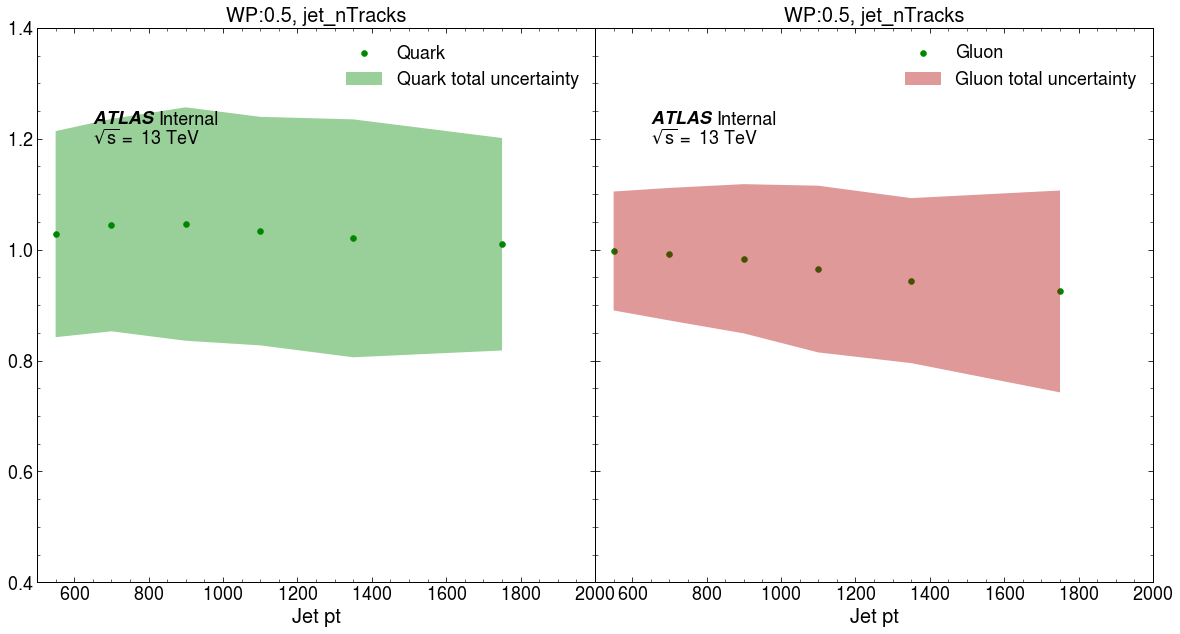

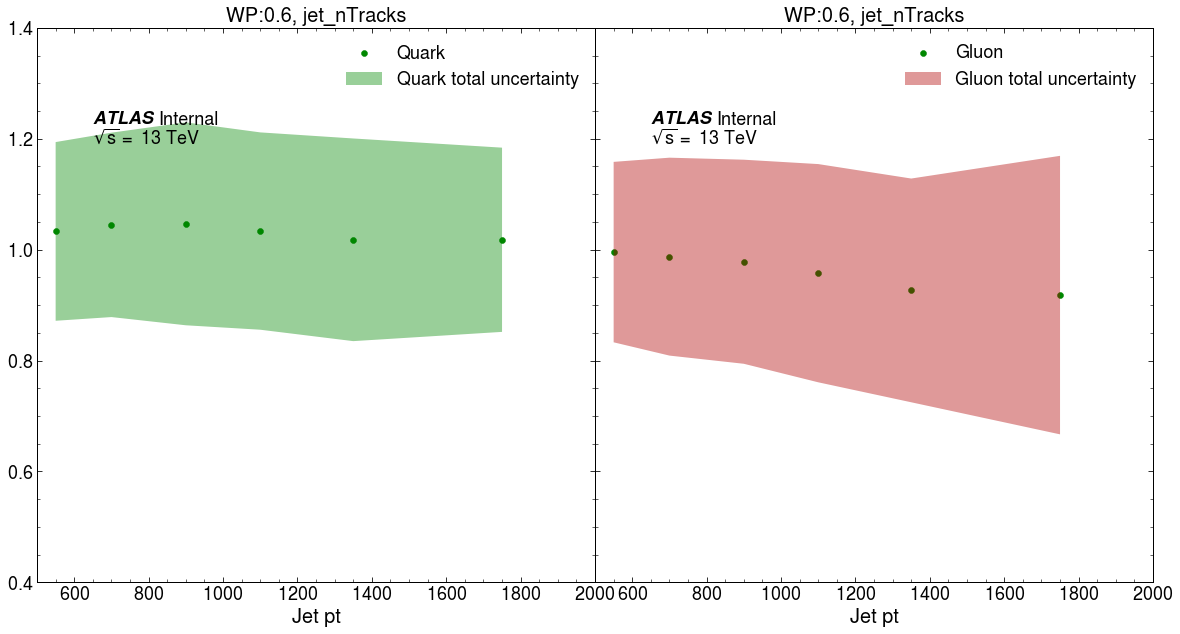

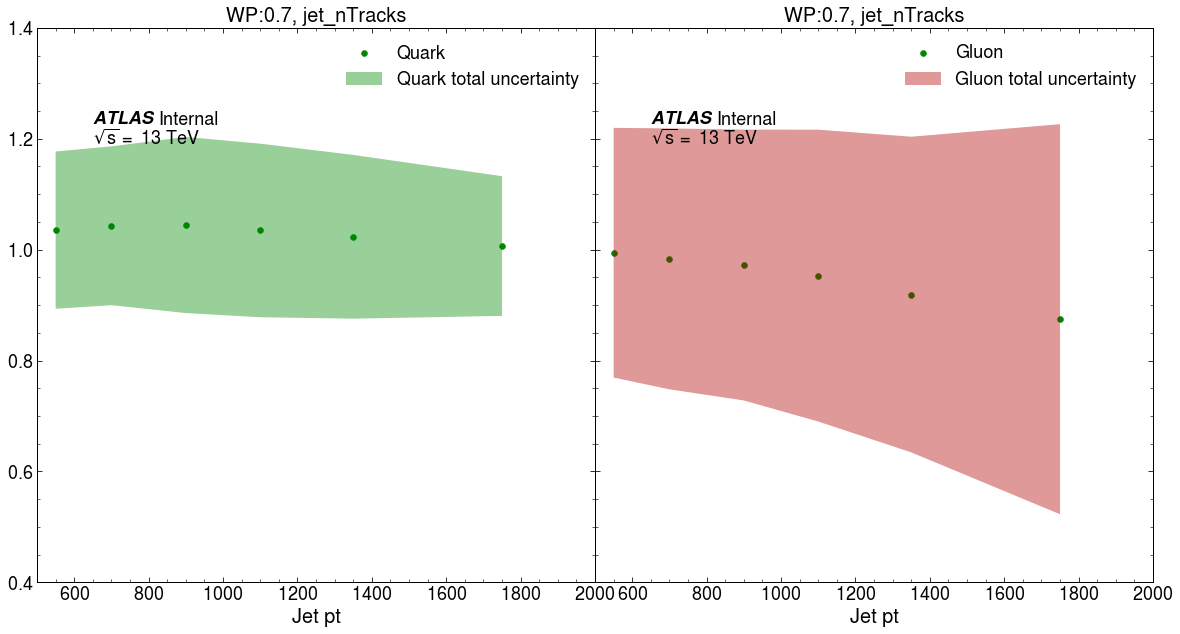

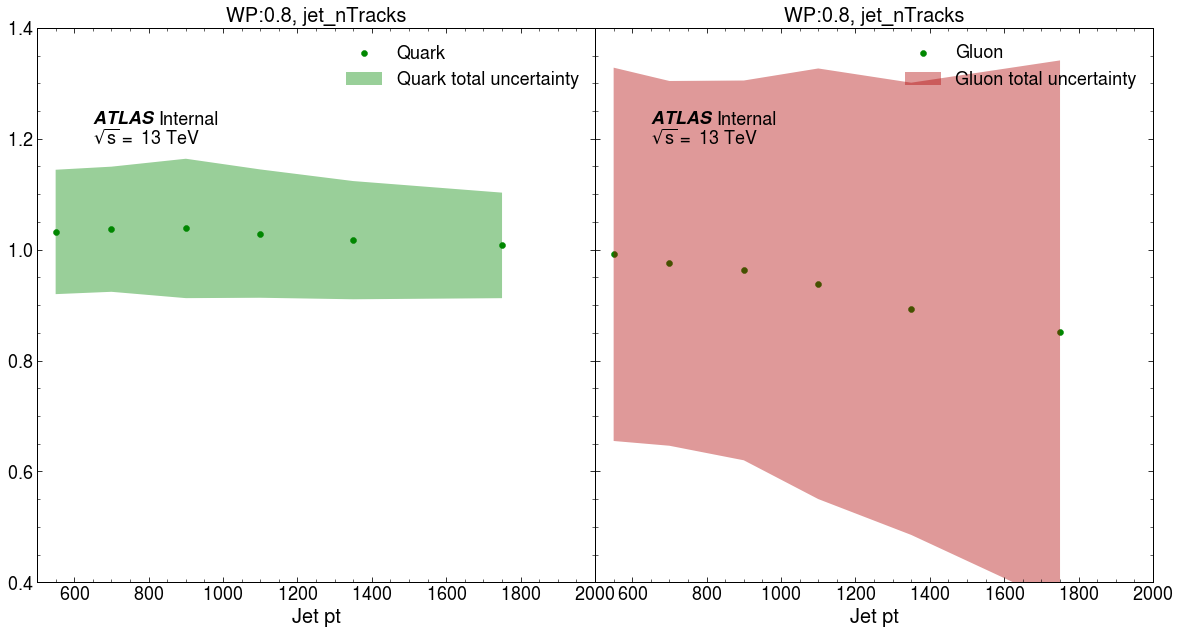

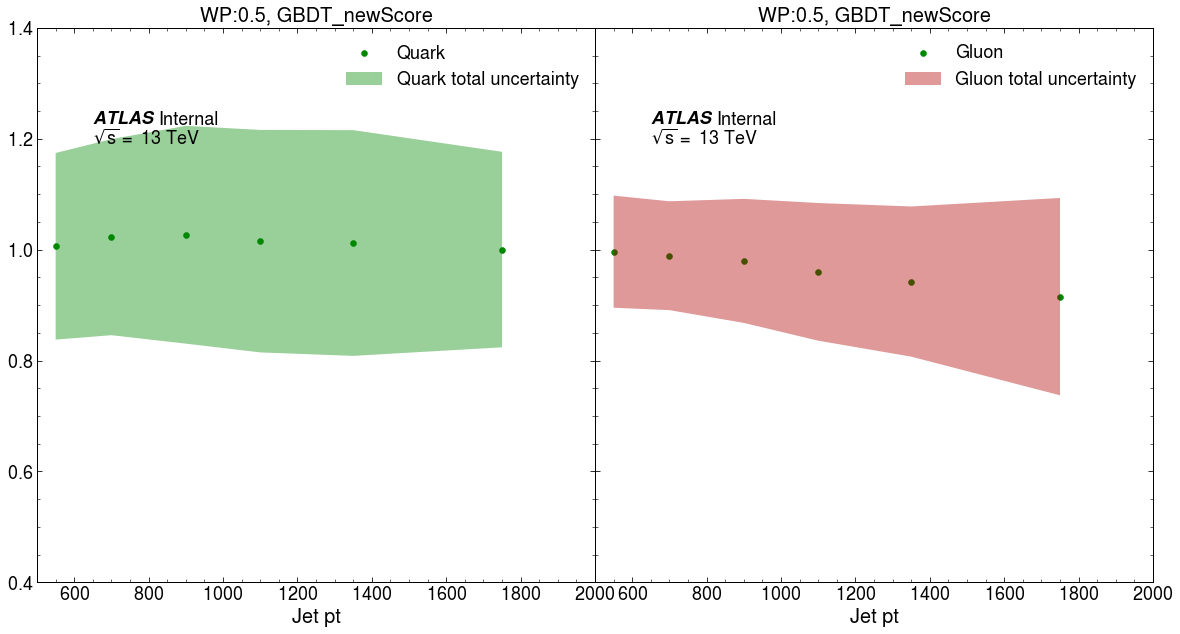

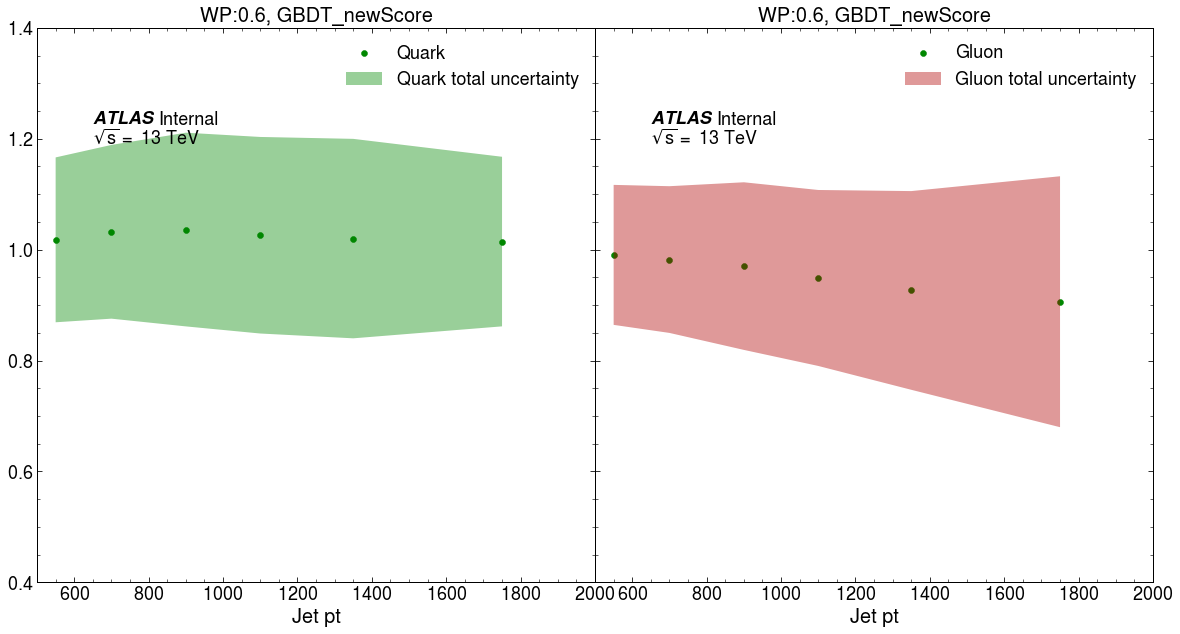

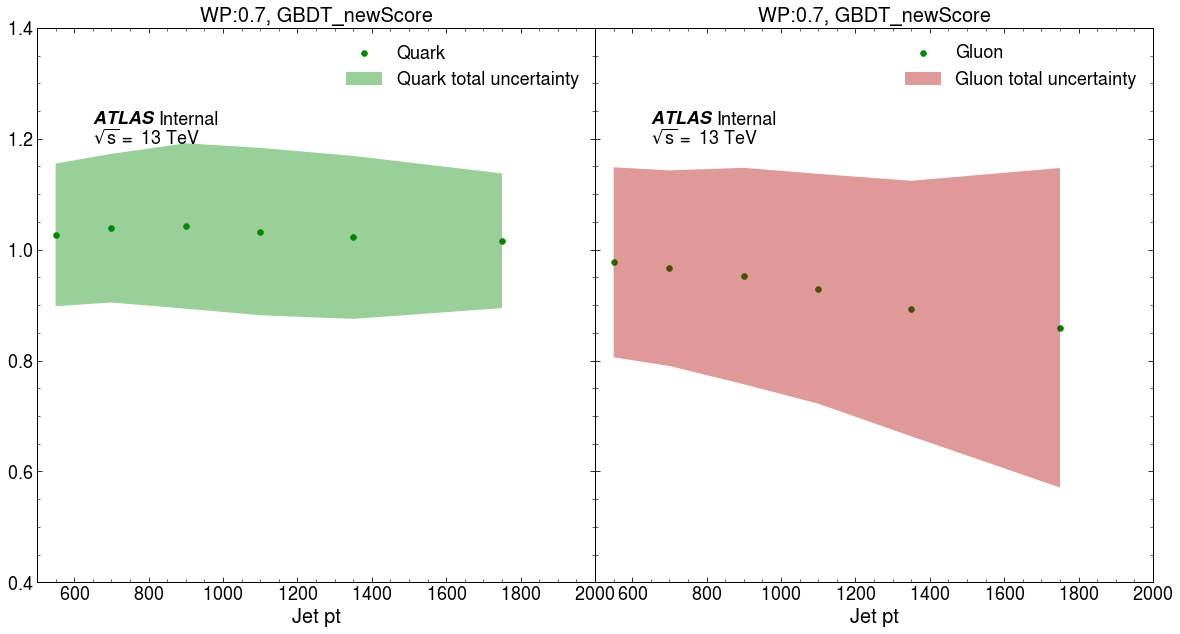

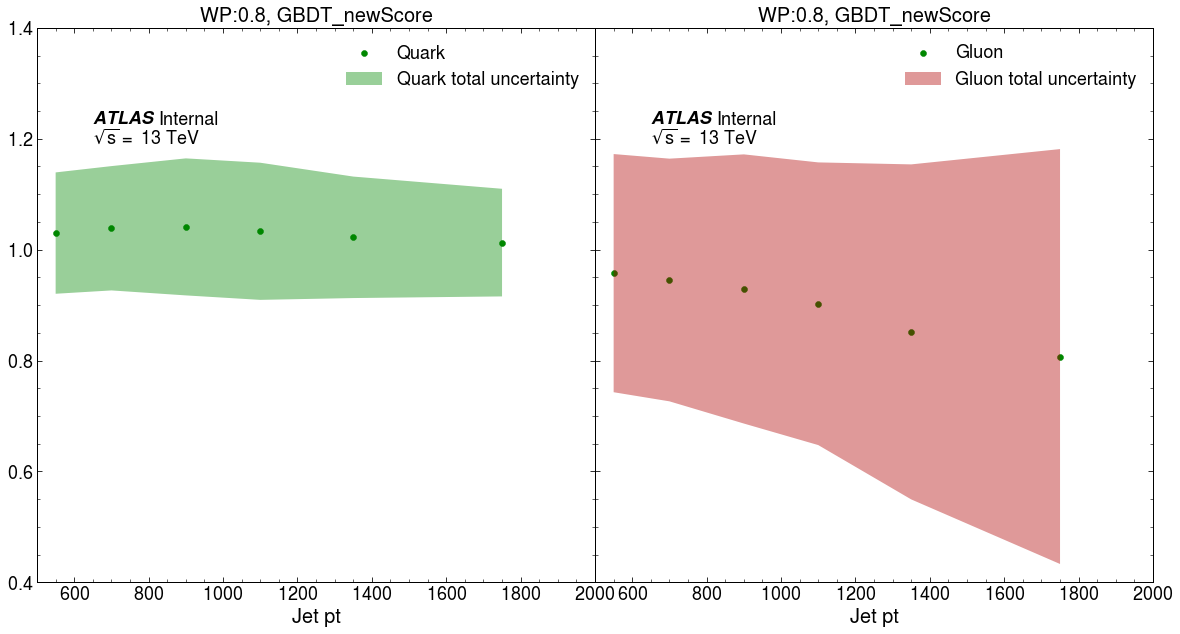

In [9]:

bin_centers = 0.5 * (np.array(label_pt_bin[:-1]) + np.array(label_pt_bin[1:]))

for i_var, reweighting_var in enumerate(reweighting_vars):

    nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'SFs_pkls'
    nominal_SFs = joblib.load(nominal_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 
    
    for WP in WPs:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True, gridspec_kw={ 'wspace': 0})
        quark_nominal_values = unumpy.nominal_values(nominal_SFs[reweighting_var][WP]['Quark'])
        gluon_nominal_values = unumpy.nominal_values(nominal_SFs[reweighting_var][WP]['Gluon'])
        ax[0].scatter(bin_centers, quark_nominal_values, label = "Quark")
        ax[1].scatter(bin_centers, gluon_nominal_values, label = "Gluon")

        quark_total_uncertainty = []
        gluon_total_uncertainty = []

        for key in syst_total[reweighting_var].keys():
            quark_total_uncertainty.append(syst_total[reweighting_var][key][WP]['Quark'])
            gluon_total_uncertainty.append(syst_total[reweighting_var][key][WP]['Gluon'])

        quark_total_uncertainty_med = quark_total_uncertainty
        gluon_total_uncertainty_med = gluon_total_uncertainty
        quark_total_uncertainty = np.sqrt(np.sum(np.power(quark_total_uncertainty, 2), axis=0))
        gluon_total_uncertainty = np.sqrt(np.sum(np.power(gluon_total_uncertainty, 2), axis=0))
        
        ax[0].fill_between(bin_centers, quark_nominal_values-quark_total_uncertainty, quark_nominal_values+quark_total_uncertainty, \
                            facecolor='C0', alpha=0.4, label=f'Quark total uncertainty')

        ax[1].fill_between(bin_centers, gluon_nominal_values-gluon_total_uncertainty, gluon_nominal_values+gluon_total_uncertainty, \
                            facecolor='C1', alpha=0.4, label=f'Gluon total uncertainty')
        
        # ax.scatter(bin_centers, unumpy.nominal_values(nominal_SFs['jet_nTracks'][WP]['Gluon']), label = "Gluon")
        for i in range(len(ax)):
            ax[i].set_xlim(label_pt_bin[0], label_pt_bin[-1])
            ax[i].set_ylim(0.4, 1.4)
            ax[i].set_title(f"WP:{WP}, {reweighting_var}")
            ax[i].set_xlabel("Jet pt")
            ax[i].legend()
            ampl.draw_atlas_label(0.1, 0.85, ax=ax[i], energy="13 TeV")

        fig.savefig(f"./syst_uncertainties/{reweighting_var}_WP{WP}_combined.jpg")


In [ ]:
quark_total_uncertainty_med

In [ ]:
quark_total_uncertainty

In [ ]:
quark_nominal_values

In [ ]:
bin_centers

In [ ]:
joblib.dump(syst_total, "syst_total.pkl")